In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy as sp
import lightkurve as lk
import pylab as pl
from IPython import display


In [2]:
star = 'TIC171591531'
# star = 'HD20203'
# star = 'HD47129'
# star = 'V647Tau'
lk_search = lk.search_lightcurve(star, mission="TESS", cadence=120)
lk_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 41,2021,SPOC,120,171591531,0.0
1,TESS Sector 54,2022,SPOC,120,171591531,0.0
2,TESS Sector 55,2022,SPOC,120,171591531,0.0


In [3]:
lc = lk_search[0].download().remove_nans().remove_outliers()

# Extract time and flux from the light curve
time = lc.time.value
flux = lc.flux.value

In [4]:
def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    amp = np.sqrt(4./len(t)) * np.sqrt(sc)

    return freq, amp

Done!


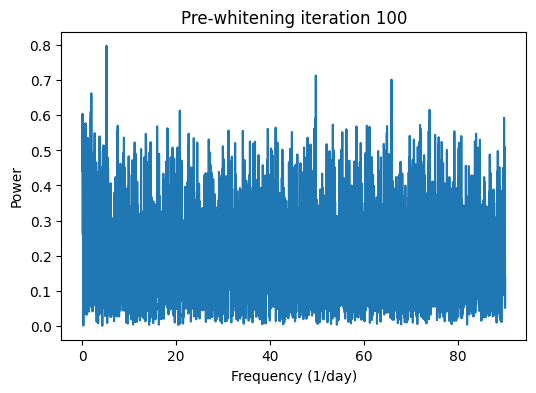

In [83]:
# Define a sinusoidal function to fit the peaks
def sinusoidal_model(t, A, omega, phi, C):
    return A * np.sin(omega * t + phi) + C

# Number of max iterations for pre-whitening
max_iterations = 100

flux_i = flux.copy()
freqs, amps = amp_spectrum(t=time, y=flux_i, fmin=None, fmax=90, nyq_mult=1., oversample_factor=5)
freqs_i = freqs.copy()
amps_i = amps.copy()
peaks = np.array([], dtype=int)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
stop = 0
for n in range(max_iterations):
    power_i = LombScargle(time, flux_i, normalization="psd").power(freqs_i)
    amps_i = 2 * (abs(power_i) / len(time)) ** 0.5

    # Find peaks in the periodogram
    peaks_tmp = find_peaks(amps_i, height=np.median(amps_i)+3*np.std(amps_i))[0]
    peaks_widths_i = sp.signal.peak_widths(amps_i, peaks=peaks_tmp)[0]
    width = np.mean(peaks_widths_i)
    distance = width/(np.median(np.diff(freqs_i))-10*np.std(np.diff(freqs_i)))
    prominence = np.median(sp.signal.peak_prominences(amps_i, peaks=peaks_tmp)[0])

    # peaks_i, _ = find_peaks(amps_i, height=np.median(amps_i)+3*np.std(amps_i), width=width, prominence=prominence, distance=distance)
    peaks_i = find_peaks(amps_i, height=np.median(amps_i)+3*np.std(amps_i), width=width, prominence=prominence)[0]
    peaks = np.append(peaks, peaks_i)

    # If no peaks are found, break the loop
    if len(peaks_i) == 0:
        # print('No significant peaks found.')
        stop += 1
        if stop>5:
            break
        else:
            peaks_i, _ = find_peaks(amps_i)
    highest_peak_id = np.argmax(amps_i[peaks_i])
    highest_peak_frequency = freqs_i[peaks_i[highest_peak_id]]
    
    # Fit a sinusoid to the original data at the frequency of the highest peak
    omega = 2 * np.pi * highest_peak_frequency
    p0 = [np.median(amps_i), omega, 0.5, 0.5]
    params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
    # perr = np.sqrt(np.diag(pcov))

    # # Subtract the fitted sinusoid from the original signal
    flux_i -= sinusoidal_model(time, *params)

    # Plot the periodogram and the folded light curve
    ax.cla()
    ax.plot(freqs_i, amps_i)
    ax.set_title(f"Pre-whitening iteration {n+1}")
    ax.set_xlabel("Frequency (1/day)")
    ax.set_ylabel("Power")
    display.display(pl.gcf())
    display.clear_output(wait=True)

peak_amps = sorted(amps[peaks], reverse=True)
## freqs of these sorted peaks
peak_freqs = freqs[peaks][np.argsort(amps[peaks])[::-1]]

# # Harmonic ratio checking
tolerance = 0.01  
harmonics_idx = []
for i in range(len(peak_freqs)):
    for j in range(i+1, len(peak_freqs)):
        ratio = peak_freqs[j]/peak_freqs[i]
        if np.abs(ratio - round(ratio)) < tolerance:
            harmonics_idx.append(j)
peak_freqs = np.delete(peak_freqs, harmonics_idx)
peak_amps = np.delete(peak_amps, harmonics_idx)
    
print('Done!')

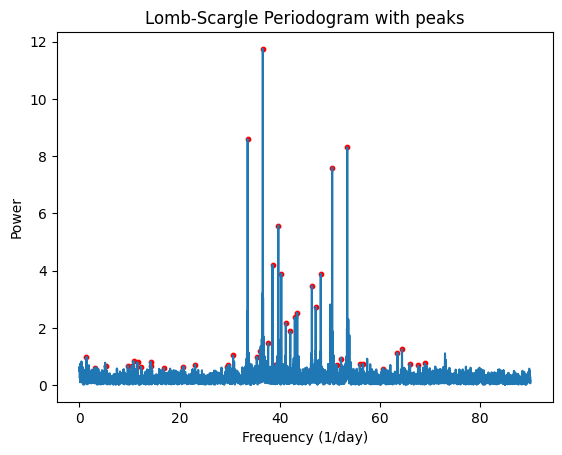

In [81]:
# Plot the final periodogram after pre-whitening
plt.figure()
plt.scatter(peak_freqs, peak_amps, s=10, color='red')
plt.plot(freqs, amps)
plt.title("Lomb-Scargle Periodogram with peaks")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
# plt.xlim(10, 40)
plt.show()

# Show the frequencies that were found
# print("Frequencies found through pre-whitening: ", freqs_at_peaks)

In [82]:
len(freqs), len(peak_freqs), len(peak_amps), len(peaks)

(11961, 45, 45, 100)

In [ ]:
# Fold the light curve at the frequency of the highest peak for visualization
highest_peak_frequency = peak_freqs[0]
folded_time = time % (1 / highest_peak_frequency)

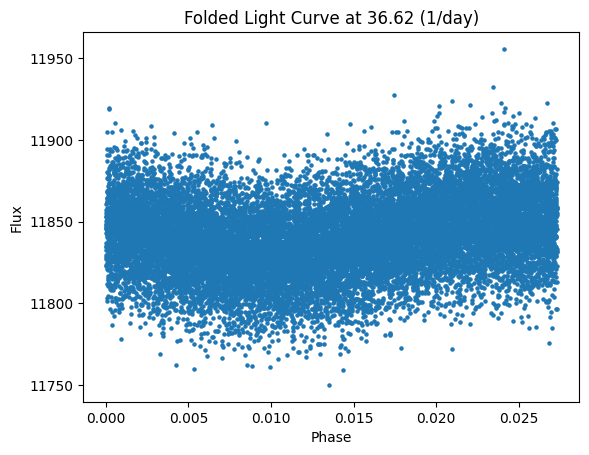

In [ ]:
# Plot folded light curve
plt.figure()
plt.scatter(folded_time, flux, s=5)
plt.title(f"Folded Light Curve at {highest_peak_frequency:.2f} (1/day)")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.show()

In [6]:
x = [1,2,3,4,5]

In [7]:
x.pop(0)

1